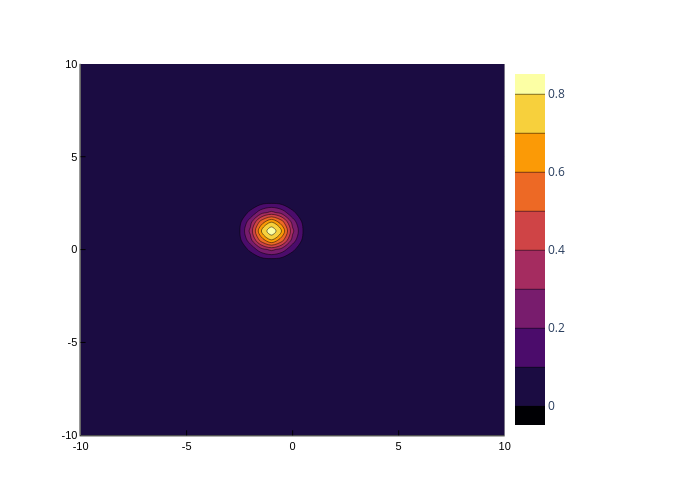

In [56]:
using Plots; plotlyjs()
using LinearAlgebra
using CUDA
using BenchmarkTools

maxPos = 10
minPos = -10
stepPos = 0.5

freePropagator(finPos, startPos, finTime, startTime = 0, m = 1) = sqrt(m / (2 * pi * im * (finTime - startTime))) * exp(im * m / (2 * (finTime - startTime)) * (finPos - startPos)^2)  
freePropagatorC(qf, qfp, q0, q0p, tf, t0) = freePropagator(qf, q0, tf, t0) + freePropagator(qfp, q0p, tf, t0)
initStateFunction(q0, q0p, σ1, s1, p1, σ2, s2, p2) = (1//2 * pi * σ1)^(1//4) * exp(-(q0 - s1)^2 / (4 * σ1^2) + im * p1 * q0) * (1//2 * pi * σ2)^(1//4) * exp(-(q0p - s2)^2 / (4 * σ2^2) + im * p2 * q0p)
posToIndex(pos) = Int32((pos - minPos) / stepPos + 1)

pos1Vect = collect(minPos:stepPos:maxPos)
pos2Vect = collect(minPos:stepPos:maxPos)
posVectSize = size(pos1Vect, 1)
posMat = [(i, j) for i in pos1Vect, j in pos2Vect]

# Entangled
# initState(q) = 1/sqrt(2) * (initStateFunction(q[1], q[2], 0.5, +1, 0, 0.5, -1, 0) + initStateFunction(q[1], q[2], 0.5, -1, 0, 0.5, +1, 0))
# Unentangled
initState(q) = initStateFunction(q[1], q[2], 0.5, +1, 0, 0.5, -1, 0)
initMat = initState.(posMat)
# initMat = round.(initMat, digits = 6)

α = 1f4
m = 1

springPropagator1(qf, qfp, q0, q0p, tf, t0) = freePropagatorC(qf, qfp, q0, q0p, tf, t0) * (1 - im * α * tf / 6 * (-2 * (m * (q0 + qf)^2 + m * (q0p + qfp)^2 + im * tf) + 2*q0*q0p + q0*qfp + q0p*qf + 2*qf*qfp))

contourf(pos1Vect, pos2Vect, abs.(initMat))

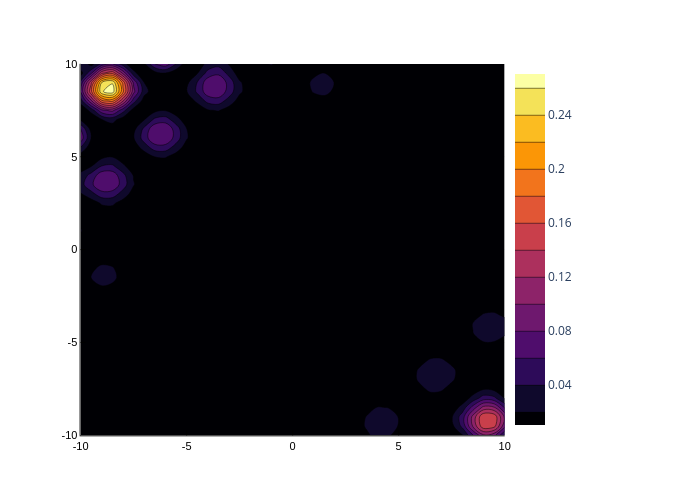

In [59]:
# Vectorized approach
# Idea: Matrix Componentwise Multiplication -> Sum
# Creating a matrix filled with propagators

finalTime = 0.2
finalMat = Matrix{ComplexF32}(undef, posVectSize, posVectSize)

function propMat!(posMat, xf, xfp)
	propMat = Matrix{ComplexF32}(undef, posVectSize, posVectSize)
	for i in eachindex(posMat)
		propMat[i] = springPropagator1(xf, xfp, posMat[i][1], posMat[i][2], finalTime, 0)
	end
	return propMat
end

for xf in pos1Vect
	for xfp in pos2Vect
		sumPos = 0
		finalMat[posToIndex(xf), posToIndex(xfp)] = sum(propMat!(posMat, xf, xfp) .* initMat)
	end
end

currentPlot = contourf(pos1Vect, pos2Vect, round.(normalize(abs2.(finalMat)), digits = 6))